# Importing

In [1]:
!pip install "tensorflow>=2.15.0"
!pip install --upgrade tensorflow-hub
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/drive/MyDrive
# Import the libraries

import os
import sys
from IPython.display import HTML, display

import numpy as np
import pandas as pd
import tensorflow as tf
from math import ceil
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import random
import time
import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional

Mounted at /content/gdrive
[Errno 2] No such file or directory: '/content/drive/MyDrive'
/content


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
# We now set the directory to access the data
def find(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

# The folder with the data and this script should be saved in your drive.
script_name = 'CourseWork_v2.ipynb'
script_path = find(script_name, '/content/gdrive/My Drive')
#DIRECTORY = '.'#os.path.dirname(script_path)
# If your Drive is too large and the "find" function takes to much time, you can set the directory manually :

#SUMMARY_PATH = '/content/drive/MyDrive/MutualFundSummary'
#SUMMARY_LABELS_PATH = '/content/drive/MyDrive/MutualFundLabels.csv'

DIRECTORY = '/content/gdrive/MyDrive/Colab Notebooks/NLP_app'

SUMMARY_PATH = '/content/gdrive/MyDrive/Colab Notebooks/NLP_app/MutualFundSummary'
SUMMARY_LABELS_PATH = '/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/MutualFundLabels.csv'

glove_word2vec = 'glove.6B.50d.txt'
our_word2vec = 'word2vec_perso.txt'

# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Save a word2vec dictionary.
def save_word2vec(filename):
    with open(os.path.join('/content/drive/MyDrive', filename),'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    with open(os.path.join('/content/drive/MyDrive', filename), encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        texts.append(summary)
        fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

# Import the data and split the training and test sets

In [3]:
# read data
#labels = pd.read_csv('/content/MutualFundLabels.csv')
labels = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/NLP_app/MutualFundLabels.csv')
labels = labels.drop('Performance fee?', axis=1)

removes = labels.loc[(labels['Ivestment Strategy']=='Long Short Funds (High Risk)')|
                     (labels['Ivestment Strategy']=='Commodities Fund (Low Risk)')]
labels_clean = labels.drop(removes.index)

fund_names, summaries = get_data(SUMMARY_PATH)
cleaned_fund_names = labels_clean['fund_name'].tolist()

# Create a dictionary to store the summaries without labels
unlabeled_summaries = {}

for name, summary in zip(fund_names, summaries):
    if name not in cleaned_fund_names:
        unlabeled_summaries[name] = summary

# Create a DataFrame with the unlabeled summaries
df_unlabeled_summaries = pd.DataFrame(data={'fund_name': list(unlabeled_summaries.keys()),
                                            'summary': list(unlabeled_summaries.values())})

# Save the unlabeled summaries as a text file
with open('unlabeled_summaries.txt', 'w', encoding='utf-8') as f:
    for summary in df_unlabeled_summaries['summary']:
        f.write(summary + '\n')

print(f"Number of summaries without labels: {len(df_unlabeled_summaries)}")

# Create a new DataFrame 'test' with only the 'summary' column from df_unlabeled_summaries
X_test = pd.DataFrame(df_unlabeled_summaries['summary'], columns=['summary'])

print(f"Number of summaries in the 'test' DataFrame: {len(X_test)}")


# Continue with the rest of the code
fund_name_counts = {name: 0 for name in fund_names}
for name in fund_names:
    if name in cleaned_fund_names:
        fund_name_counts[name] += 1

single_occurrences = {name: count for name, count in fund_name_counts.items() if count == 1}
print(f"Number of matching fund names that appear exactly once: {len(single_occurrences)}")

multiple_occurrences = {name: count for name, count in fund_name_counts.items() if count > 1}
if multiple_occurrences:
    print(f"There are fund names that appear more than once:")
    for name, count in multiple_occurrences.items():
        print(f"{name}: {count} times")
else:
    print("No fund names appear more than once.")

labels_clean_filtered = labels_clean[labels_clean['fund_name'].isin(fund_names)]
df_summaries = pd.DataFrame(data={'fund_name':fund_names, 'summary':summaries})
merge = labels_clean_filtered.merge(df_summaries, on=['fund_name'], how='left')

Number of summaries without labels: 84
Number of summaries in the 'test' DataFrame: 84
Number of matching fund names that appear exactly once: 461
No fund names appear more than once.


In [4]:
import pandas as pd
first_row_string = X_test.head(1).to_string(index=False, max_colwidth=1000)
print(first_row_string)


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 summary

In [5]:
merge

,id,fund_name,Ivestment Strategy,Leverage?,Portfolio composition,Concentration,summary
0,0000051931-18-000151,American Funds College 2018 Fund,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2018 Fund\n\nInvestment...
1,0000051931-18-000151,American Funds College 2021 Fund,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2021 Fund\n\nInvestment...
2,0000051931-18-000151,American Funds College 2024 Fund,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2024 Fund\n\nInvestment...
3,0000051931-18-000151,American Funds College 2027 Fund,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2027 Fund\n\nInvestment...
4,0000051931-18-000151,American Funds College 2030 Fund,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2030 Fund\n\nInvestment...
...,...,...,...,...,...,...,...
456,0001710607-18-000172,American Century Diversified Corporate Bond ETF,Fixed Income Long Only (Low Risk),Yes,Investment grade securities,Diversified,Fund Summary\nInvestment Objective\nThe fund s...
457,0001710607-18-000172,American Century Diversified Municipal Bond ETF,Fixed Income Long Only (Low Risk),No,Investment grade securities,Diversified,Fund Summary\nInvestment Objective\nThe fund s...
458,0001710607-18-000172,American Century Quality Diversified Internati...,Equity Long Only (Low Risk),Yes,Sub-investment grade securities or emerging ma...,Diversified,Fund Summary\nInvestment Objective\nThe fund s...
459,0001710607-18-000172,American Century STOXX U.S. Quality Growth ETF,Equity Long Only (Low Risk),Yes,Listed Equities,Diversified,Fund Summary\nInvestment Objective\nThe fund s...


In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(merge['summary'], merge['Ivestment Strategy'], test_size=0.2, random_state=42)

Cleaning data and word segmentation

In [11]:
stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])

# clean and tokenize without lemmatizing
def tokenizer(txt):
    txt = txt.replace('\n', ' ').replace('\t', ' ').lower()
    word_tokens = word_tokenize(txt)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = [w for w in filtered_sentence if re.sub("[^A-Za-z ]+",'',w) != '']
    return filtered_sentence

train_text_words = np.concatenate([tokenizer(summary) for summary in X_train])

train_text_words[:20]

array(['fund', 'summary', 'fund/class', 'fidelity®', 'emerging',
       'markets', 'fund/fidelity®', 'emerging', 'markets', 'fund',
       'investment', 'objective', 'fund', 'seeks', 'capital',
       'appreciation', 'fee', 'table', 'following', 'table'], dtype='<U44')

# Skip-gram Model

In [12]:
# Training parameters
batch_size = 128
num_epochs = 3

# Word2vec parameters
embedding_size = 50
max_vocabulary_size = 5000
min_occurrence = 10
skip_window = 3
num_skips = 4

count = [('UNK', -1)]
count.extend(collections.Counter(train_text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        break

word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)

data = list()
unk_count = 0
for word in train_text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)

# build OneHot vector from index
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

# Generate training batch for the skip-gram model
def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    data_index = 0
    while True :
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        # batch is filled with 128 inputs
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        # labels is filled with 128 outputs
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = 2 * skip_window + 1
        # buffer keep track of the visited indexes visited
        buffer = collections.deque(maxlen=span)
        if data_index + span > len(data):
            data_index = 0
            # We stop the loop when we went through all the corpus
            break
        buffer.extend(data[data_index:data_index + span])
        data_index += span
        for i in range(batch_size // num_skips):
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # Randomly select num_skips words in the context
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                # Creates one raw data
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_index == len(data):
                buffer.extend(data[0:span])
                data_index = span
            else:
                buffer.append(data[data_index])
                data_index += 1
        # Backtrack a little bit to avoid skipping words in the end of a batch
        data_index = (data_index + len(data) - span) % len(data)

        # translate word index to on-hot representation
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])

        # output one batch
        yield batch_one_hot, labels_one_hot

In [13]:
# Create en compile the Autoencoder
def creat_word2vec_model():
    input_word = Input(shape=(vocab_size,))

    encoded = Dense(embedding_size, activation='linear')(input_word)
    decoded = Dense(vocab_size, activation='softmax')(encoded)

    autoencoder = Model(input_word, decoded)
    encoder = Model(input_word, encoded)

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return encoder, autoencoder

encoder, autoencoder = creat_word2vec_model()
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2999)]            0         
                                                                 
 dense_3 (Dense)             (None, 50)                150000    
                                                                 
 dense_4 (Dense)             (None, 2999)              152949    
                                                                 
Total params: 302949 (1.16 MB)
Trainable params: 302949 (1.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)

Epoch 1/3


<ipython-input-14-a9705c45700e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)


5104/5104 [==============================] - 24s 4ms/step - loss: 0.0178
Epoch 2/3
5104/5104 [==============================] - 22s 4ms/step - loss: 0.0025
Epoch 3/3
5104/5104 [==============================] - 21s 4ms/step - loss: 0.0025


In [15]:
def vecotrize(word):
    word_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([word_one_hot]))[0]

word2vec = {w : vecotrize(w) for w in word2id.keys()}
save_word2vec('/content/gdrive/MyDrive/Colab Notebooks/NLP_app/train_word2vec')

1/1 [==============================] - 0s 18ms/step


In [16]:
import pickle
with open('/content/gdrive/MyDrive/Colab Notebooks/NLP_app/word2vec.pkl', 'wb') as f:
    pickle.dump(word2vec, f)

In [17]:
import pickle
with open('/content/gdrive/MyDrive/Colab Notebooks/NLP_app/word2vec.pkl', 'rb') as f:
    loaded_word2vec = pickle.load(f)

print(loaded_word2vec['applies'])

[-0.4776214  -0.43160453 -0.40469468  0.5253271   0.46126422 -0.42970693
 -0.4013467  -0.4303584   0.40016693 -0.36533937 -0.46974504 -0.41502059
 -0.5276573   0.46139935  0.57935184  0.3899326   0.4003326   0.49478552
 -0.49479198 -0.4029701  -0.5676773  -0.4237062   0.48605755  0.48504037
  0.4448225  -0.4366344   0.47607708  0.49601078 -0.5164473  -0.50867677
  0.4292785  -0.47134334 -0.5709676  -0.36545202 -0.38259298 -0.42962977
  0.38379455 -0.43382466  0.59649754  0.4006846  -0.44548285  0.42155936
 -0.39406797  0.3354493   0.39522356  0.413185    0.45294565 -0.4948534
  0.36604223  0.27605644]


In [18]:
def lemma_tokenizer(text):
    lemmatizer=WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in word_tokenize(text.replace("'"," "))]

stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''","’"]+["]","[","*"]+['doe', 'ha', 'wa'] +['--']+ [''])

In [19]:
max_features = 18
tfidf = TfidfVectorizer(input='content', tokenizer=lemma_tokenizer, stop_words=list(stop_words), max_features=max_features)
tfidf_train = tfidf.fit_transform(X_train)
key_words = tfidf.get_feature_names_out()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [20]:
key_words

array(['class', 'company', 'expense', 'fee', 'fund', 'investment',
       'market', 'may', 'performance', 'portfolio', 'rate', 'return',
       'risk', 'security', 'share', 'tax', 'value', 'year'], dtype=object)

In [21]:
def get_n_closer(word, n, word2vec):
    vect = word2vec[word]
    dist_dict = {k: cosine(v, vect) for k, v in word2vec.items()}
    closer_words = []
    for _ in range(n):
        min_key = min(dist_dict.keys(), key=lambda k: dist_dict[k])
        closer_words.append(min_key)
        del dist_dict[min_key]
    return closer_words

##knowledge base
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words) :
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in word2vec')

        knowledge_base.update(neighbors)

        out.update(progress(ii, len(key_words)-1))
    return knowledge_base

knowledge_base = create_knowledge_base(5, loaded_word2vec, key_words)
print(knowledge_base)

# Takes a summary, the knowledge base and some hyper parameters and returns the "num_sent" sentences
# of the summary that are closer to the the knowledge base in term of spacial distances.
def extract_sentence_distance(summary, knowledge, n_closer, n_reject, num_sent):
    # Split the summary into sentences.
    sentences = sent_tokenize(summary)
    sentence_scores = []
    # Loop over the sentences.
    for j, sentence in enumerate(sentences):
        # we tokenize and clean the sentence
        tokens = tokenizer(sentence)

        sentence_barycentre = np.zeros(embedding_size)
        effective_len = 0
        # Compute the barycentre of the sentence
        for token in tokens :
            try :
                sentence_barycentre += np.array(loaded_word2vec[token])
                effective_len += 1
            except KeyError :
                pass
            except :
                raise

        # Reject sentences with less than n_reject words in our word2vec map
        if effective_len <= n_reject :
            sentence_scores.append(1)

        else :
            sentence_barycentre = sentence_barycentre/effective_len
            # Compute the distance sentece_barycentre -> words in our knowledge base
            barycentre_distance = [cosine(sentence_barycentre, loaded_word2vec[key_word]) for key_word in knowledge]
            barycentre_distance.sort()
            # Create the score of the sentence by averaging the "n_closer" smallest distances
            score = np.mean(barycentre_distance[:n_closer])
            sentence_scores.append(score)
    # Select the "num_sent" sentences that have the smallest score (smallest distance score with the knowledge base)
    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[:num_sent]
    return ' '.join(top_sentences)



{'risk', 'tax', 'r6', 'fund', 'turnover', 'fee', 'reimbursement', 'issuer', 'exempt', 'turns', 'securities', 'fiscal', 'c', 'debt', 'expense', 'personal', 'class', 'reimbursements', 'value', 'another', 'may', 'year', 'objective', 'acquired', 'classes', 'holdings', 'past', 'decline', 'sectors', 'n', 'increase', '12b-1', 'state', 'investment', 'market', 'foreign', 'generally', 'return', 'recent', 'inception', 'portfolio', 'december', 'assumes', 'markets', 'shows', 'decrease', 'achieve', 'exposure', 'performance', 'floating', 'years', 'company', 'lack', 'result', 'b', 'security', 'following', 'waiver', 'r', 'waivers', 'cause', 'recommend', 'conditions', 'rate', 'marginal', 'meet', 'pays', 'ended', 'pay', 'credit', 'indicate', 'distributions', 'share', 'remain', 'institutional', 'taxes', 'affect', 'well'}


In [22]:
len(knowledge_base)

78

# Measure Distance

In [23]:
#prepare the train,validation and test dataframe
X_train_df = pd.DataFrame(X_train)
X_valid_df = pd.DataFrame(X_valid)
X_test_df = pd.DataFrame(X_test)

embedding_size = 50

X_train_df['sentences_distance'] = X_train_df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)
X_valid_df['sentences_distance'] = X_valid_df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)
X_test_df['sentences_distance'] = X_test_df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)

In [24]:
def extract_sentence_match(summary, knowledge, num_sent):
    sentences = sent_tokenize(summary)
    sentence_scores = []
    for j, sentence in enumerate(sentences):
        set_tokens = set(tokenizer(sentence))

        # Find the number of common words between the knowledge base and the sentence
        inter_knwoledge = set_tokens.intersection(knowledge)

        sentence_scores.append(len(inter_knwoledge))

    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[len(sentences)-num_sent-1:]
    return ' '.join(top_sentences)

X_train_df['sentences_match'] = X_train_df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)
X_valid_df['sentences_match'] = X_valid_df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)
X_test_df['sentences_match'] = X_test_df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)

# produce train_X and test_X
train_X = X_train_df['sentences_match'].values
train_X = [' '.join(tokenizer(txt)) for txt in train_X]

valid_X = X_valid_df['sentences_match'].values
valid_X = [' '.join(tokenizer(txt)) for txt in valid_X]

test_X = X_test_df['sentences_match'].values
test_X = [' '.join(tokenizer(txt)) for txt in test_X]

# produce train_y and valid_y
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

encoder = LabelEncoder()

encoded_train_y = encoder.fit_transform(y_train)
label_train_y = to_categorical(encoded_train_y, num_classes=3)

encoded_valid_y = encoder.transform(y_valid)
label_valid_y = to_categorical(encoded_valid_y, num_classes=3)


num_words = 2500 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 150 # Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
word_dimension = 50 # dimension of our word vectors.

keras_tokenizer = Tokenizer(num_words=num_words)

keras_tokenizer.fit_on_texts(train_X)

word_index = keras_tokenizer.word_index

sequences_train = keras_tokenizer.texts_to_sequences(train_X)
sequences_valid = keras_tokenizer.texts_to_sequences(valid_X)
sequences_test = keras_tokenizer.texts_to_sequences(test_X)

# truncate or lenthen each text so they have the same length.
feature_train = pad_sequences(sequences_train, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_valid = pad_sequences(sequences_valid, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test = pad_sequences(sequences_test, maxlen=maxlen, dtype=float, padding='post', truncating='post')

# create our embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    embedding_vector = loaded_word2vec.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [40]:
# Convert the encoded validation labels back to the original categories
decoded_valid_y = encoder.inverse_transform(encoded_valid_y)

# classifier

## CNN1

In [ ]:
import time
from keras.callbacks import ModelCheckpoint

def create_CNN_model():
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=True))
    CNN.add(Convolution1D(64, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))
    CNN.add(Convolution1D(32, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))
    CNN.add(Flatten())
    CNN.add(Dense(units = 128 , activation = 'relu'))
    CNN.add(Dropout(0.7))
    CNN.add(Dense(units = 3, activation = 'softmax'))
    CNN.compile(optimizer = 'RMSprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return CNN

CNN_model = create_CNN_model()

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
start_time = time.time()

CNN_history = CNN_model.fit(feature_train, label_train_y,
                             epochs=800, batch_size=128,
                             validation_data=(feature_valid, label_valid_y),
                             callbacks=[checkpoint])

end_time = time.time()

training_time = end_time - start_time

print(f"Training time: {training_time:.2f} seconds")
CNN_model.summary()

Epoch 1/800
3/3 [==============================] - ETA: 0s - loss: 1.2352 - accuracy: 0.3750
Epoch 1: val_accuracy improved from -inf to 0.46237, saving model to best_model.h5
3/3 [==============================] - 2s 260ms/step - loss: 1.2352 - accuracy: 0.3750 - val_loss: 1.0439 - val_accuracy: 0.4624
Epoch 2/800
1/3 [=========>....................] - ETA: 0s - loss: 1.0337 - accuracy: 0.5234

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - ETA: 0s - loss: 1.0206 - accuracy: 0.5380
Epoch 2: val_accuracy did not improve from 0.46237
3/3 [==============================] - 0s 136ms/step - loss: 1.0206 - accuracy: 0.5380 - val_loss: 1.0312 - val_accuracy: 0.4624
Epoch 3/800
3/3 [==============================] - ETA: 0s - loss: 0.9966 - accuracy: 0.5353
Epoch 3: val_accuracy did not improve from 0.46237
3/3 [==============================] - 0s 136ms/step - loss: 0.9966 - accuracy: 0.5353 - val_loss: 1.0254 - val_accuracy: 0.4624
Epoch 4/800
3/3 [==============================] - ETA: 0s - loss: 0.9990 - accuracy: 0.5679
Epoch 4: val_accuracy did not improve from 0.46237
3/3 [==============================] - 0s 75ms/step - loss: 0.9990 - accuracy: 0.5679 - val_loss: 1.0376 - val_accuracy: 0.4624
Epoch 5/800
3/3 [==============================] - ETA: 0s - loss: 0.9656 - accuracy: 0.5435
Epoch 5: val_accuracy did not improve from 0.46237
3/3 [==============================] - 0s 135ms/st

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [ ]:
y_valid_CNN = CNN_model.predict(feature_valid)

# convert the validation vector
valid_y_CNN = y_valid_CNN.copy()
for i in range(len(y_valid_CNN)):
    j = np.where(y_valid_CNN[i] == np.amax(y_valid_CNN[i]))
    valid_y_CNN[i] = [0, 0, 0]
    valid_y_CNN[i][j] = 1

print(accuracy_score(label_valid_y,valid_y_CNN))
print(classification_report(label_valid_y,valid_y_CNN))
print("auc score: ",roc_auc_score(label_valid_y,valid_y_CNN))

3/3 [==============================] - 0s 3ms/step
0.7419354838709677
              precision    recall  f1-score   support

           0       0.92      0.65      0.76        17
           1       0.69      0.88      0.78        43
           2       0.77      0.61      0.68        33

   micro avg       0.74      0.74      0.74        93
   macro avg       0.79      0.71      0.74        93
weighted avg       0.76      0.74      0.74        93
 samples avg       0.74      0.74      0.74        93

auc score:  0.7806137441809556


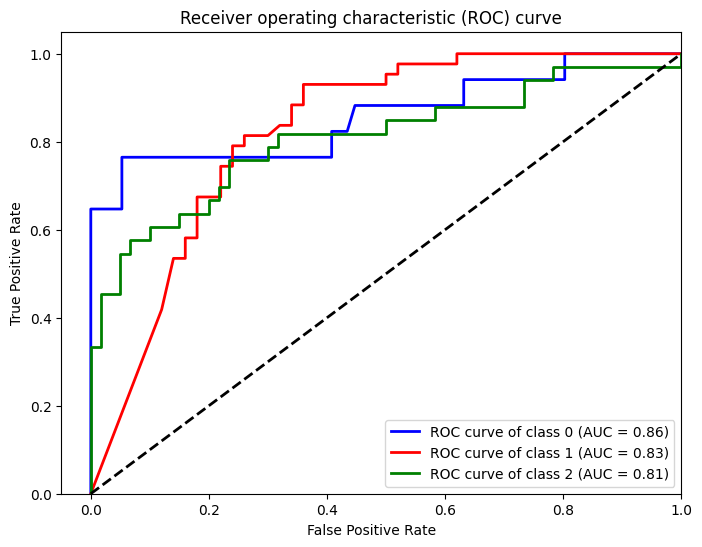

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Convert labels to binary form (assuming three-class classification)
y_valid_binary = label_binarize(label_valid_y, classes=[0, 1, 2])

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_valid_binary[:, i], y_valid_CNN[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plot ROC curve
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc='lower right')
plt.show()

## CNN2

In [ ]:
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.optimizers import RMSprop


def create_CNN_model():
    CNN = Sequential()
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=True))

    CNN.add(Convolution1D(256, 3, activation = 'relu'))
    CNN.add(BatchNormalization())
    CNN.add(MaxPooling1D(pool_size = 3))

    CNN.add(Convolution1D(128, 3, activation = 'relu'))
    CNN.add(BatchNormalization())
    CNN.add(MaxPooling1D(pool_size = 3))

    CNN.add(Convolution1D(64, 3, activation = 'relu'))
    CNN.add(BatchNormalization())
    CNN.add(MaxPooling1D(pool_size = 3))

    CNN.add(Flatten())
    CNN.add(Dense(units = 512 , activation = 'relu', kernel_regularizer=l2(0.01)))
    CNN.add(Dropout(0.5))
    CNN.add(Dense(units = 256 , activation = 'relu', kernel_regularizer=l2(0.01)))
    CNN.add(Dropout(0.5))
    CNN.add(Dense(units = 3, activation = 'softmax'))

    opt = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)

    #opt = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
    CNN.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return CNN


CNN_model = create_CNN_model()

checkpoint = ModelCheckpoint(filepath='best_model.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

class_weights = {0: 1.5, 1: 0.5, 2: 3.0}

start_time = time.time()

CNN_history = CNN_model.fit(feature_train, label_train_y,
                            epochs=800, batch_size=128,
                            validation_data=(feature_valid, label_valid_y),
                            class_weight=class_weights,
                            callbacks=[checkpoint])


end_time = time.time()

training_time = end_time - start_time

print(f"Training time: {training_time:.2f} seconds")
CNN_model.summary()

Epoch 1/800
3/3 [==============================] - ETA: 0s - loss: 9.5611 - accuracy: 0.3533
Epoch 1: val_accuracy improved from -inf to 0.35484, saving model to best_model.h5
3/3 [==============================] - 3s 231ms/step - loss: 9.5611 - accuracy: 0.3533 - val_loss: 7.6720 - val_accuracy: 0.3548
Epoch 2/800
2/3 [===================>..........] - ETA: 0s - loss: 7.9070 - accuracy: 0.4414

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - ETA: 0s - loss: 7.8620 - accuracy: 0.4212
Epoch 2: val_accuracy did not improve from 0.35484
3/3 [==============================] - 0s 82ms/step - loss: 7.8620 - accuracy: 0.4212 - val_loss: 7.4695 - val_accuracy: 0.3548
Epoch 3/800
3/3 [==============================] - ETA: 0s - loss: 7.1773 - accuracy: 0.5951
Epoch 3: val_accuracy did not improve from 0.35484
3/3 [==============================] - 0s 82ms/step - loss: 7.1773 - accuracy: 0.5951 - val_loss: 7.2898 - val_accuracy: 0.3548
Epoch 4/800
3/3 [==============================] - ETA: 0s - loss: 6.8958 - accuracy: 0.6467
Epoch 4: val_accuracy improved from 0.35484 to 0.45161, saving model to best_model.h5
3/3 [==============================] - 0s 110ms/step - loss: 6.8958 - accuracy: 0.6467 - val_loss: 7.1171 - val_accuracy: 0.4516
Epoch 5/800
1/3 [=========>....................] - ETA: 0s - loss: 6.7254 - accuracy: 0.7656
Epoch 5: val_accuracy improved from 0.45161 to 0.50538, saving mode

In [ ]:
y_valid_CNN = CNN_model.predict(feature_valid)

# convert the validation vector
valid_y_CNN = y_valid_CNN.copy()
for i in range(len(y_valid_CNN)):
    j = np.where(y_valid_CNN[i] == np.amax(y_valid_CNN[i]))
    valid_y_CNN[i] = [0, 0, 0]
    valid_y_CNN[i][j] = 1

print(accuracy_score(label_valid_y,valid_y_CNN))
print(classification_report(label_valid_y,valid_y_CNN))
print("auc score: ",roc_auc_score(label_valid_y,valid_y_CNN))

3/3 [==============================] - 0s 3ms/step
0.8064516129032258
              precision    recall  f1-score   support

           0       0.91      0.59      0.71        17
           1       0.84      0.84      0.84        43
           2       0.74      0.88      0.81        33

   micro avg       0.81      0.81      0.81        93
   macro avg       0.83      0.77      0.79        93
weighted avg       0.82      0.81      0.80        93
 samples avg       0.81      0.81      0.81        93

auc score:  0.8307346523045998


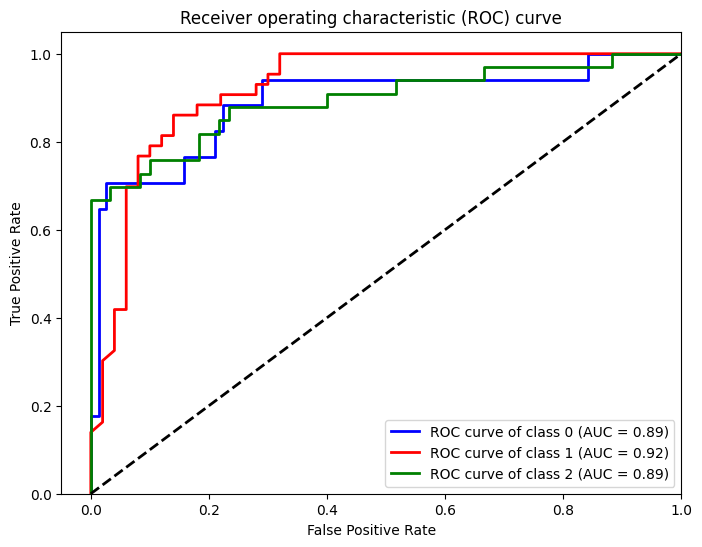

In [ ]:
# Convert labels to binary form (assuming three-class classification)
y_valid_binary = label_binarize(label_valid_y, classes=[0, 1, 2])

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_valid_binary[:, i], y_valid_CNN[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plot ROC curve
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc='lower right')
plt.show()

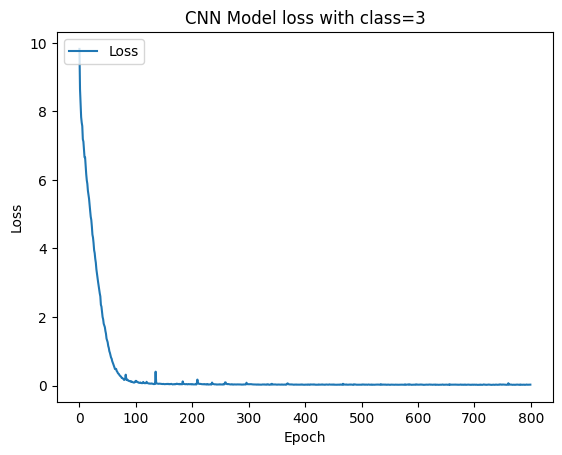

In [ ]:
# Plot training loss values
plt.plot(CNN_history.history['loss'])
plt.title('CNN Model loss with class=3')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper left')
plt.show()

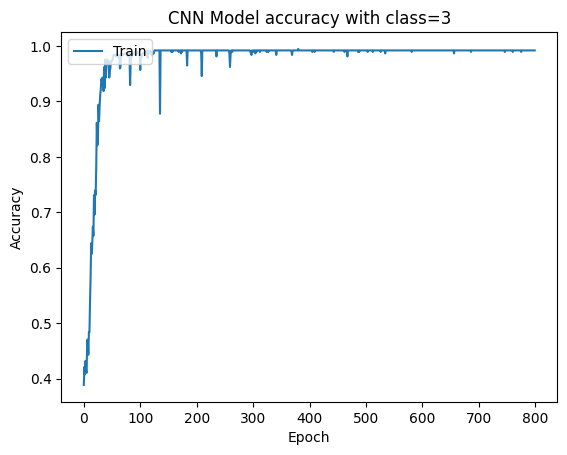

In [ ]:
plt.plot(CNN_history.history['accuracy'])
plt.title('CNN Model accuracy with class=3')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

## RNN

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

def create_RNN_model():
    RNN = Sequential()
    RNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=True))
    RNN.add(Bidirectional(LSTM(word_dimension, return_sequences=True)))
    RNN.add(Dropout(0.3))
    RNN.add(Bidirectional(LSTM(word_dimension, return_sequences=True)))
    RNN.add(Dropout(0.3))
    RNN.add(Bidirectional(LSTM(word_dimension)))
    RNN.add(Dense(word_dimension, activation='relu'))
    RNN.add(Dropout(0.3))
    RNN.add(Dense(3, activation='softmax'))

    opt = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)

    #opt = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
    RNN.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    #RNN.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return RNN

RNN_model = create_RNN_model()

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

start_time = time.time()

RNN_history = RNN_model.fit(feature_train, label_train_y, epochs=800, batch_size=128, validation_data=(feature_valid, label_valid_y), callbacks=[checkpoint])

end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")
RNN_model.summary()

RNN_model.load_weights('best_model.h5')

Epoch 1/800
3/3 [==============================] - ETA: 0s - loss: 1.0593 - accuracy: 0.5109
Epoch 1: val_accuracy improved from -inf to 0.48387, saving model to best_model.h5
3/3 [==============================] - 10s 1s/step - loss: 1.0593 - accuracy: 0.5109 - val_loss: 1.0626 - val_accuracy: 0.4839
Epoch 2/800
1/3 [=========>....................] - ETA: 0s - loss: 1.0700 - accuracy: 0.4062

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - ETA: 0s - loss: 1.0288 - accuracy: 0.5217
Epoch 2: val_accuracy did not improve from 0.48387
3/3 [==============================] - 0s 120ms/step - loss: 1.0288 - accuracy: 0.5217 - val_loss: 1.0388 - val_accuracy: 0.4624
Epoch 3/800
3/3 [==============================] - ETA: 0s - loss: 0.9885 - accuracy: 0.5516
Epoch 3: val_accuracy did not improve from 0.48387
3/3 [==============================] - 0s 120ms/step - loss: 0.9885 - accuracy: 0.5516 - val_loss: 1.0426 - val_accuracy: 0.4624
Epoch 4/800
3/3 [==============================] - ETA: 0s - loss: 0.9848 - accuracy: 0.5543
Epoch 4: val_accuracy did not improve from 0.48387
3/3 [==============================] - 0s 113ms/step - loss: 0.9848 - accuracy: 0.5543 - val_loss: 1.0581 - val_accuracy: 0.4624
Epoch 5/800
2/3 [===================>..........] - ETA: 0s - loss: 1.0284 - accuracy: 0.5078
Epoch 5: val_accuracy did not improve from 0.48387
3/3 [==============================] - 0s 87ms/st

In [ ]:
# validation with the RNN
y_valid_RNN = RNN_model.predict(feature_valid)
valid_y_RNN = y_valid_RNN.copy()
for i in range(len(y_valid_RNN)):
    j = np.where(y_valid_RNN[i] == np.amax(y_valid_RNN[i]))
    valid_y_RNN[i] = [0, 0, 0]
    valid_y_RNN[i][j] = 1

# print acc and report
print(accuracy_score(label_valid_y,valid_y_RNN))
print(classification_report(label_valid_y,valid_y_RNN))
print("auc score: ",roc_auc_score(label_valid_y,valid_y_RNN))

3/3 [==============================] - 3s 16ms/step
0.8279569892473119
              precision    recall  f1-score   support

           0       0.78      0.82      0.80        17
           1       0.89      0.79      0.84        43
           2       0.78      0.88      0.83        33

   micro avg       0.83      0.83      0.83        93
   macro avg       0.82      0.83      0.82        93
weighted avg       0.83      0.83      0.83        93
 samples avg       0.83      0.83      0.83        93

auc score:  0.8711750087817481


In [ ]:
y_test_RNN = RNN_model.predict(feature_test)

3/3 [==============================] - 0s 14ms/step


## CNN+RNN

In [ ]:
from keras.layers import Bidirectional, GRU, LSTM, Attention, GlobalMaxPooling1D, Dense, Dropout, Input, Concatenate, Conv1D, MaxPooling1D
from keras.models import Model

def create_CNN_RNN_model():
    inputs = Input(shape=(maxlen,))
    embeddings = Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=True)(inputs)

    conv1 = Conv1D(128, 3, activation='relu')(embeddings)
    pool1 = MaxPooling1D(3)(conv1)
    conv2 = Conv1D(128, 3, activation='relu')(pool1)
    pool2 = MaxPooling1D(3)(conv2)

    gru1 = Bidirectional(GRU(128, return_sequences=True))(pool2)
    gru2 = Bidirectional(GRU(64, return_sequences=True))(gru1)

    lstm1 = Bidirectional(LSTM(128, return_sequences=True))(pool2)
    lstm2 = Bidirectional(LSTM(64, return_sequences=True))(lstm1)

    concat = Concatenate(axis=-1)([gru2, lstm2])

    attention = Attention()([concat, concat])

    pool = GlobalMaxPooling1D()(attention)

    dense1 = Dense(128, activation='relu')(pool)
    dropout1 = Dropout(0.5)(dense1)

    dense2 = Dense(64, activation='relu')(dropout1)
    dropout2 = Dropout(0.5)(dense2)

    outputs = Dense(3, activation='softmax')(dropout2)

    model = Model(inputs=inputs, outputs=outputs)

    #opt = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)

    opt = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model



In [ ]:
start_time = time.time()

CNN_RNN_model = create_CNN_RNN_model()

CNN_RNN_history = CNN_RNN_model.fit(feature_train, label_train_y, epochs=800, batch_size=128, validation_data=(feature_valid, label_valid_y))

end_time = time.time()

training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")
CNN_RNN_model.summary()

CNN_RNN_model.load_weights('best_model.CNN_RNN')


Epoch 1/800
3/3 [==============================] - 13s 1s/step - loss: 1.0996 - accuracy: 0.3995 - val_loss: 1.1081 - val_accuracy: 0.3333
Epoch 2/800
3/3 [==============================] - 0s 85ms/step - loss: 1.0729 - accuracy: 0.4293 - val_loss: 1.0974 - val_accuracy: 0.4624
Epoch 3/800
3/3 [==============================] - 0s 88ms/step - loss: 1.0689 - accuracy: 0.4620 - val_loss: 1.0854 - val_accuracy: 0.4624
Epoch 4/800
3/3 [==============================] - 0s 61ms/step - loss: 1.0664 - accuracy: 0.4783 - val_loss: 1.0753 - val_accuracy: 0.4624
Epoch 5/800
3/3 [==============================] - 0s 85ms/step - loss: 1.0451 - accuracy: 0.5027 - val_loss: 1.0675 - val_accuracy: 0.4624
Epoch 6/800
3/3 [==============================] - 0s 83ms/step - loss: 1.0431 - accuracy: 0.5027 - val_loss: 1.0617 - val_accuracy: 0.4624
Epoch 7/800
3/3 [==============================] - 0s 107ms/step - loss: 1.0272 - accuracy: 0.5462 - val_loss: 1.0578 - val_accuracy: 0.4624
Epoch 8/800
3/3 [===

In [ ]:
# validation with the RNN
y_valid_CNN_RNN = CNN_RNN_model.predict(feature_valid)
valid_y_CNN_RNN = y_valid_CNN_RNN.copy()
for i in range(len(y_valid_CNN_RNN)):
    j = np.where(y_valid_CNN_RNN[i] == np.amax(y_valid_CNN_RNN[i]))
    valid_y_CNN_RNN[i] = [0, 0, 0]
    valid_y_CNN_RNN[i][j] = 1

# print acc and report
print(accuracy_score(label_valid_y,valid_y_CNN_RNN))
print(classification_report(label_valid_y,valid_y_CNN_RNN))
print("auc score: ",roc_auc_score(label_valid_y,valid_y_CNN_RNN))

3/3 [==============================] - 2s 53ms/step
0.7204301075268817
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        17
           1       0.73      0.86      0.79        43
           2       0.72      0.55      0.62        33

   micro avg       0.72      0.72      0.72        93
   macro avg       0.72      0.70      0.70        93
weighted avg       0.72      0.72      0.71        93
 samples avg       0.72      0.72      0.72        93

auc score:  0.7748909790539859


# try not using knowledgebase

## CNN1

In [7]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

# Load the pre-trained BERT model and tokenizer
bert_model_name = 'distilbert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = TFBertModel.from_pretrained(bert_model_name)

# Define function to convert text to BERT input format
def convert_text_to_bert_input(text):
    # Tokenize the text
    tokens = tokenizer.tokenize(text)

    # Truncate or pad tokens to the specified length
    max_length = 512
    if len(tokens) > max_length - 2:
        tokens = tokens[:max_length - 2]
    tokens = ['[CLS]'] + tokens + ['[SEP]']

    # Convert tokens to ids
    token_ids = tokenizer.convert_tokens_to_ids(tokens)

    # Create attention mask
    attention_mask = [1] * len(token_ids)

    # Pad token_ids and attention_mask to specified lengths
    padding_length = max_length - len(token_ids)
    token_ids += [0] * padding_length
    attention_mask += [0] * padding_length

    return token_ids, attention_mask

# Convert each text in X_train to BERT input format
bert_input = []
for text in X_train:
    token_ids, attention_mask = convert_text_to_bert_input(text)
    bert_input.append((token_ids, attention_mask))

# Convert BERT input to tensorflow Dataset
bert_input_dataset = tf.data.Dataset.from_generator(
    lambda: bert_input,
    output_types=(tf.int32, tf.int32),
    output_shapes=((None,), (None,))
)

# Extract features using BERT model
feature_train = []
for token_ids, attention_mask in bert_input_dataset:
    token_ids = tf.reshape(token_ids, (1, -1))
    attention_mask = tf.reshape(attention_mask, (1, -1))
    outputs = bert_model(token_ids, attention_mask=attention_mask)
    pooled_output = outputs.pooler_output
    feature_train.append(pooled_output)

feature_train = tf.concat(feature_train, axis=0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['distilbert.transformer.layer.0.output_layer_norm.weight', 'distilbert.transformer.layer.5.output_layer_norm.weight', 'distilbert.transformer.layer.4.output_layer_norm.bias', 'distilbert.transformer.layer.2.attention.v_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.3.output_layer_norm.bias', 'distilbert.transformer.layer.3.attention.v_lin.weight', 'vocab_projector.bias', 'distilbert.transformer.layer.5.attention.out_lin.bias', 'distilbert.transformer.layer.4.attention.v_lin.weight', 'distilbert.transformer.layer.3.attention.out_lin.weight', 'distilbert.transformer.layer.2.attention.q_lin.weight', 'distilbert.transformer.layer.5.attention.v_lin.weight', 'distilbert.transformer.layer.3.ffn.lin1.bias', 'distilbert.transformer.layer.3.ffn.lin2.bias', 'distilbert.transformer.layer.0.attention.out_lin.weight', 'distilbert.transformer.layer.2.atte

In [9]:
bert_input_valid = []
for text in X_valid:
    token_ids, attention_mask = convert_text_to_bert_input(text)
    bert_input_valid.append((token_ids, attention_mask))

bert_input_valid_dataset = tf.data.Dataset.from_generator(
    lambda: bert_input_valid,
    output_types=(tf.int32, tf.int32),
    output_shapes=((None,), (None,))
)

feature_valid = []
for token_ids, attention_mask in bert_input_valid_dataset:
    token_ids = tf.reshape(token_ids, (1, -1))
    attention_mask = tf.reshape(attention_mask, (1, -1))
    outputs = bert_model(token_ids, attention_mask=attention_mask)
    pooled_output = outputs.pooler_output
    feature_valid.append(pooled_output)

feature_valid = tf.concat(feature_valid, axis=0)

# process X_test
bert_input_test = []
for text in X_test:
    token_ids, attention_mask = convert_text_to_bert_input(text)
    bert_input_test.append((token_ids, attention_mask))

bert_input_test_dataset = tf.data.Dataset.from_generator(
    lambda: bert_input_test,
    output_types=(tf.int32, tf.int32),
    output_shapes=((None,), (None,))
)

feature_test = []
for token_ids, attention_mask in bert_input_test_dataset:
    token_ids = tf.reshape(token_ids, (1, -1))
    attention_mask = tf.reshape(attention_mask, (1, -1))
    outputs = bert_model(token_ids, attention_mask=attention_mask)
    pooled_output = outputs.pooler_output
    feature_test.append(pooled_output)

feature_test = tf.concat(feature_test, axis=0)

In [ ]:
from tensorflow.keras.layers import Reshape
from keras.optimizers import Adam

def create_CNN_model(bert_output_dim):
    CNN = Sequential()
    CNN.add(Reshape((bert_output_dim, 1), input_shape=(bert_output_dim,)))
    CNN.add(Convolution1D(64, 5, activation='relu'))
    CNN.add(MaxPooling1D(pool_size=5))
    CNN.add(Convolution1D(32, 5, activation='relu'))
    CNN.add(MaxPooling1D(pool_size=5))
    CNN.add(Flatten())
    CNN.add(Dense(units=128, activation='relu'))
    CNN.add(Dropout(0.3))
    CNN.add(Dense(units=3, activation='softmax'))
    #opt = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)

    #opt = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
    opt = Adam(learning_rate=0.001)

    CNN.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return CNN


bert_output_dim = feature_train.shape[1]  # Get dimensions of BERT features

CNN_model = create_CNN_model(bert_output_dim)

checkpoint = ModelCheckpoint('best_model.bert_cnn', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

start_time = time.time()

CNN_history = CNN_model.fit(feature_train, label_train_y, epochs=800, batch_size=128,
                            validation_data=(feature_valid, label_valid_y),callbacks=[checkpoint])

#RNN_history = RNN_model.fit(feature_train, label_train_y, epochs=800, batch_size=128, validation_data=(feature_valid, label_valid_y), callbacks=[checkpoint])

end_time = time.time()
training_time = end_time - start_time

print(f"Training time: {training_time:.2f} seconds")
CNN_model.summary()

CNN_model.load_weights('best_model.bert_cnn')



Epoch 1/800
1/3 [=========>....................] - ETA: 2s - loss: 1.1039 - accuracy: 0.2969
Epoch 1: val_accuracy improved from -inf to 0.46237, saving model to best_model.bert_cnn
3/3 [==============================] - 2s 551ms/step - loss: 1.0486 - accuracy: 0.4620 - val_loss: 1.1209 - val_accuracy: 0.4624
Epoch 2/800
1/3 [=========>....................] - ETA: 0s - loss: 0.9453 - accuracy: 0.5938
Epoch 2: val_accuracy did not improve from 0.46237
3/3 [==============================] - 0s 19ms/step - loss: 0.9942 - accuracy: 0.5543 - val_loss: 1.0470 - val_accuracy: 0.4624
Epoch 3/800
1/3 [=========>....................] - ETA: 0s - loss: 0.9848 - accuracy: 0.5625
Epoch 3: val_accuracy did not improve from 0.46237
3/3 [==============================] - 0s 18ms/step - loss: 1.0160 - accuracy: 0.5543 - val_loss: 1.0382 - val_accuracy: 0.4624
Epoch 4/800
1/3 [=========>....................] - ETA: 0s - loss: 0.9946 - accuracy: 0.5781
Epoch 4: val_accuracy did not improve from 0.46237
3

In [ ]:
y_valid_CNN = CNN_model.predict(feature_valid)

# convert the validation vector
valid_y_CNN = y_valid_CNN.copy()
for i in range(len(y_valid_CNN)):
    j = np.where(y_valid_CNN[i] == np.amax(y_valid_CNN[i]))
    valid_y_CNN[i] = [0, 0, 0]
    valid_y_CNN[i][j] = 1

print(accuracy_score(label_valid_y,valid_y_CNN))
print(classification_report(label_valid_y,valid_y_CNN))
print("auc score: ",roc_auc_score(label_valid_y,valid_y_CNN))

3/3 [==============================] - 0s 3ms/step
0.8279569892473119
              precision    recall  f1-score   support

           0       0.83      0.59      0.69        17
           1       0.84      0.88      0.86        43
           2       0.81      0.88      0.84        33

   micro avg       0.83      0.83      0.83        93
   macro avg       0.83      0.78      0.80        93
weighted avg       0.83      0.83      0.82        93
 samples avg       0.83      0.83      0.83        93

auc score:  0.8446269411662888


## CNN2

In [30]:
from keras.layers import BatchNormalization, Reshape
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

def create_CNN_model(bert_output_dim):
    CNN = Sequential()
    CNN.add(Reshape((bert_output_dim, 1), input_shape=(bert_output_dim,)))
    CNN.add(Convolution1D(256, 3, activation='relu', kernel_regularizer=l2(0.01)))
    CNN.add(BatchNormalization())
    CNN.add(MaxPooling1D(pool_size=3))
    CNN.add(Convolution1D(128, 3, activation='relu', kernel_regularizer=l2(0.01)))
    CNN.add(BatchNormalization())
    CNN.add(MaxPooling1D(pool_size=3))
    CNN.add(Convolution1D(64, 3, activation='relu', kernel_regularizer=l2(0.01)))
    CNN.add(BatchNormalization())
    CNN.add(MaxPooling1D(pool_size=3))
    CNN.add(Flatten())
    CNN.add(Dense(units=512, activation='relu', kernel_regularizer=l2(0.02)))
    CNN.add(Dropout(0.1))
    CNN.add(Dense(units=256, activation='relu', kernel_regularizer=l2(0.02)))
    CNN.add(Dropout(0.1))
    CNN.add(Dense(units=3, activation='softmax'))

    #opt = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)

    #opt = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

    opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=True)

    CNN.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return CNN

bert_output_dim = feature_train.shape[1]
CNN_model = create_CNN_model(bert_output_dim)

start_time = time.time()

checkpoint = ModelCheckpoint(filepath='best_model.bert_cnn2', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
class_weights = {0: 1.5, 1: 0.5, 2: 2.0}

CNN_history = CNN_model.fit(feature_train, label_train_y, epochs=800, batch_size=128,
                            validation_data=(feature_valid, label_valid_y),callbacks=[checkpoint])
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")
CNN_model.summary()

CNN_model.load_weights('best_model.bert_cnn2')

Epoch 1/800
1/3 [=========>....................] - ETA: 6s - loss: 17.3915 - accuracy: 0.4297
Epoch 1: val_accuracy improved from -inf to 0.46237, saving model to best_model.bert_cnn2
3/3 [==============================] - 5s 1s/step - loss: 17.1577 - accuracy: 0.5299 - val_loss: 21.8110 - val_accuracy: 0.4624
Epoch 2/800
1/3 [=========>....................] - ETA: 0s - loss: 16.2514 - accuracy: 0.7266
Epoch 2: val_accuracy did not improve from 0.46237
3/3 [==============================] - 0s 23ms/step - loss: 15.9041 - accuracy: 0.7418 - val_loss: 18.4467 - val_accuracy: 0.4624
Epoch 3/800
1/3 [=========>....................] - ETA: 0s - loss: 15.2832 - accuracy: 0.7344
Epoch 3: val_accuracy did not improve from 0.46237
3/3 [==============================] - 0s 24ms/step - loss: 14.9048 - accuracy: 0.8234 - val_loss: 16.1910 - val_accuracy: 0.4624
Epoch 4/800
1/3 [=========>....................] - ETA: 0s - loss: 14.2552 - accuracy: 0.8438
Epoch 4: val_accuracy did not improve from 0

In [31]:
y_valid_CNN = CNN_model.predict(feature_valid)

# convert the validation vector
valid_y_CNN = y_valid_CNN.copy()
for i in range(len(y_valid_CNN)):
    j = np.where(y_valid_CNN[i] == np.amax(y_valid_CNN[i]))
    valid_y_CNN[i] = [0, 0, 0]
    valid_y_CNN[i][j] = 1

print(accuracy_score(label_valid_y,valid_y_CNN))
print(classification_report(label_valid_y,valid_y_CNN))
print("auc score: ",roc_auc_score(label_valid_y,valid_y_CNN))

3/3 [==============================] - 0s 3ms/step
0.8064516129032258
              precision    recall  f1-score   support

           0       1.00      0.65      0.79        17
           1       0.75      0.98      0.85        43
           2       0.85      0.67      0.75        33

   micro avg       0.81      0.81      0.81        93
   macro avg       0.87      0.76      0.79        93
weighted avg       0.83      0.81      0.80        93
 samples avg       0.81      0.81      0.81        93

auc score:  0.8239671682626538


In [32]:
y_test_CNN = CNN_model.predict(feature_test)

3/3 [==============================] - 0s 118ms/step


In [33]:
y_test_CNN

array([[0.24741028, 0.55530953, 0.19728017],
       [0.07243354, 0.8241285 , 0.10343787],
       [0.8430379 , 0.05493788, 0.1020242 ],
       [0.01613153, 0.6175939 , 0.3662746 ],
       [0.02990755, 0.91982126, 0.05027116],
       [0.08245869, 0.67659116, 0.24095012],
       [0.17795613, 0.65812516, 0.16391869],
       [0.02782135, 0.3405363 , 0.63164234],
       [0.03166941, 0.8486824 , 0.11964817],
       [0.01635834, 0.83802414, 0.14561749],
       [0.02219802, 0.4640859 , 0.5137161 ],
       [0.10905071, 0.22776647, 0.66318285],
       [0.1431077 , 0.64083403, 0.21605824],
       [0.12714824, 0.06180232, 0.8110494 ],
       [0.21866202, 0.32880884, 0.4525292 ],
       [0.87571365, 0.02563402, 0.09865234],
       [0.02833551, 0.7125686 , 0.25909588],
       [0.06249561, 0.45984706, 0.4776574 ],
       [0.09373659, 0.16809456, 0.73816884],
       [0.09500759, 0.7316869 , 0.17330556],
       [0.09081985, 0.50242513, 0.406755  ],
       [0.08108315, 0.77213335, 0.14678349],
       [0.

In [34]:
# convert the test vector
test_y_CNN = y_test_CNN.copy()
for i in range(len(y_test_CNN)):
    j = np.where(y_test_CNN[i] == np.amax(y_test_CNN[i]))
    test_y_CNN[i] = [0, 0, 0]
    test_y_CNN[i][j] = 1

In [35]:
test_y_CNN

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1

In [37]:
import pandas as pd

test_y_CNN_df = pd.DataFrame(test_y_CNN)

file_path = '/content/gdrive/MyDrive/Colab Notebooks/NLP_app/y_test_CNN.csv'
test_y_CNN_df.to_csv(file_path, index=False)


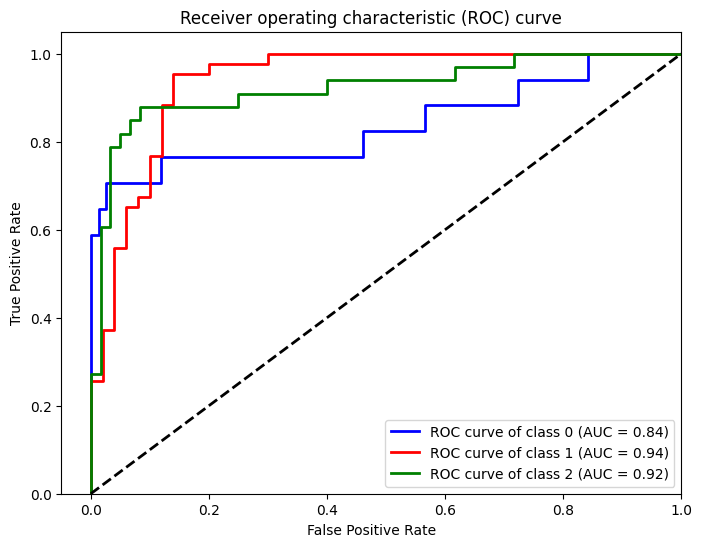

In [ ]:
y_valid_binary = label_binarize(label_valid_y, classes=[0, 1, 2])

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_valid_binary[:, i], y_valid_CNN[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc='lower right')
plt.show()

## RNN

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import RMSprop

feature_train = tf.reshape(feature_train, shape=(-1, 1, 768))
feature_valid = tf.reshape(feature_valid, shape=(-1, 1, 768))

def create_RNN_model(input_shape):
    RNN = Sequential()
    RNN.add(Bidirectional(LSTM(768, return_sequences=True), input_shape=input_shape))
    RNN.add(Dropout(0.2))
    RNN.add(Bidirectional(LSTM(768, return_sequences=True)))
    RNN.add(Dropout(0.2))
    RNN.add(Bidirectional(LSTM(768)))
    RNN.add(Dense(768, activation='relu'))
    RNN.add(Dropout(0.1))
    RNN.add(Dense(3, activation='softmax'))
    opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=True)
    #opt = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)
    RNN.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return RNN

RNN_model = create_RNN_model(input_shape=(1, 768))


checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

start_time = time.time()
RNN_history = RNN_model.fit(feature_train, label_train_y, epochs=800, batch_size=128, validation_data=(feature_valid, label_valid_y), callbacks=[checkpoint])
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

RNN_model.summary()

RNN_model.load_weights('best_model.h5')

Epoch 1/800
1/3 [=========>....................] - ETA: 18s - loss: 1.0987 - accuracy: 0.3359
Epoch 1: val_accuracy improved from -inf to 0.46237, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 11s 956ms/step - loss: 1.1543 - accuracy: 0.4891 - val_loss: 1.0408 - val_accuracy: 0.4624
Epoch 2/800
1/3 [=========>....................] - ETA: 0s - loss: 1.0012 - accuracy: 0.5547
Epoch 2: val_accuracy did not improve from 0.46237
3/3 [==============================] - 0s 33ms/step - loss: 1.0351 - accuracy: 0.5543 - val_loss: 1.0676 - val_accuracy: 0.4624
Epoch 3/800
1/3 [=========>....................] - ETA: 0s - loss: 1.0484 - accuracy: 0.5547
Epoch 3: val_accuracy did not improve from 0.46237
3/3 [==============================] - 0s 32ms/step - loss: 1.0390 - accuracy: 0.5543 - val_loss: 1.0488 - val_accuracy: 0.4624
Epoch 4/800
1/3 [=========>....................] - ETA: 0s - loss: 1.0397 - accuracy: 0.4922
Epoch 4: val_accuracy did not improve from 0.46237
3/3 [==============================] - 0s 35ms/step - loss: 0.9876 - accuracy: 0.5543 - val_loss: 1.0875 - val_accuracy: 0.4624
Epoch 5/800
1/3 [=========>....................] - ETA

In [ ]:
# validation with the RNN
y_valid_RNN = RNN_model.predict(feature_valid)
valid_y_RNN = y_valid_RNN.copy()
for i in range(len(y_valid_RNN)):
    j = np.where(y_valid_RNN[i] == np.amax(y_valid_RNN[i]))
    valid_y_RNN[i] = [0, 0, 0]
    valid_y_RNN[i][j] = 1

# print acc and report
print(accuracy_score(label_valid_y,valid_y_RNN))
print(classification_report(label_valid_y,valid_y_RNN))
print("auc score: ",roc_auc_score(label_valid_y,valid_y_RNN))

3/3 [==============================] - 1s 4ms/step
0.8387096774193549
              precision    recall  f1-score   support

           0       1.00      0.59      0.74        17
           1       0.81      0.91      0.86        43
           2       0.83      0.88      0.85        33

   micro avg       0.84      0.84      0.84        93
   macro avg       0.88      0.79      0.82        93
weighted avg       0.85      0.84      0.83        93
 samples avg       0.84      0.84      0.84        93

auc score:  0.8489999861819287
